In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [1003]:
targets_df= pd.read_csv('../0_data/subset_targets.csv')

In [900]:
from pubval import PubChemValidator
pcv = PubChemValidator(None, None, None)

In [1009]:
pcv.load_checkpoint()
print(len(pcv.predictions))

49101


In [1185]:
import tqdm
import pandas as pd

df = pd.DataFrame(columns=['tid', 'pref_name', 'lig_chemblid', 'aid', 'outcome', 'title','nnrank', 'prob'])
count = 0 
acts = list()

inacts= list()
probs= list()
nns = list()
for pred in tqdm.tqdm_notebook(pcv.predictions.keys()):
    lig, targ = pred.split(':')
    try:
        target_synonyms = pcv.targets[targ]['synonyms']
        tid = pcv.targets[targ]['tid']
        pref_name = pcv.targets[targ]['pref_name']
        
        ligand_chemblid = pcv.ligands[lig]['chemblid']
    
        assays = pcv.ligands[lig]['assays']
    except:
        continue
        
    act = 0
    inact = 0
    unspec = 0
    
    nn = pcv.predictions[pred]['nn']
    prob = float(pcv.predictions[pred]['prob'])
    
    for a in assays:
        aid = a[0]
        title = a[2]
        clean_title = pcv.clean_text(title)

        
        num = len(set(target_synonyms).intersection(clean_title.split()))
        if num>0:
            outcome =  a[1]
            if outcome=='Unspecified':
                unspec+=1
            if outcome=='Active':
                act+=1
            if outcome=='Inactive':
                inact+=1
            if outcome in ['Active', 'Inactive']:
                df.loc[count] = [tid, pref_name, ligand_chemblid, aid, outcome, title, nn, prob]
                count+=1
    if sum([act, inact])>0:
        
        nns.append(nn)
        acts.append(act)
        inacts.append(inact)
        probs.append(float(prob))

acts = np.array(acts)
inacts = np.array(inacts)
nns =np.array(nns)
probs = np.array(probs)

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


# Do some pandas rearranging:

In [1186]:
#save all raw data:
df.sort_values(by='pref_name').to_csv('results.csv')

In [1187]:
#aggregate the multiple assays for each protein-ligand pair into an 'active', 'inactive', or 'equal' record. 

piv = df.pivot_table(index=['pref_name','lig_chemblid', 'prob', 'nnrank'], 
               columns='outcome', 
               aggfunc='size', 
               fill_value=0)
res = piv.reset_index()
res['result'] = np.sign(res['Active'] - res['Inactive'])
res['result'] = res['result'].apply(lambda x: {-1:'Inactive', 0:'Both', 1:'Active'}[x])
result = res.drop('Active', axis=1).drop('Inactive', axis=1)
result.reset_index(drop=True, inplace=True)#.head()
result

outcome,pref_name,lig_chemblid,prob,nnrank,result
0,3-phosphoinositide dependent protein kinase-1,CHEMBL2347053,0.455495,13.5,Active
1,3-phosphoinositide dependent protein kinase-1,CHEMBL3884319,0.504447,27.5,Active
2,ADAM17,CHEMBL43704,0.365403,2.0,Inactive
3,Acetylcholinesterase,CHEMBL240045,0.672720,1.0,Inactive
4,Acetylcholinesterase,CHEMBL322343,0.667318,1.0,Active
...,...,...,...,...,...
1006,c-Jun N-terminal kinase 1,CHEMBL535,0.941916,34.0,Inactive
1007,c-Jun N-terminal kinase 1,CHEMBL553,0.829682,49.0,Inactive
1008,c-Jun N-terminal kinase 1,CHEMBL91829,0.586161,21.0,Inactive
1009,c-Jun N-terminal kinase 1,CHEMBL939,0.695681,34.0,Inactive


# Start plotting

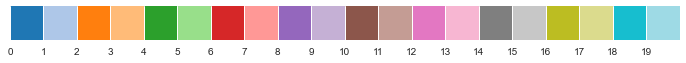

In [1301]:
from matplotlib import colors

def plot_fig_label(ax, lab):
    ax.text(0, 1.1, lab, transform=ax.transAxes,
        fontsize=24, va='top', ha='left')

def makeCmap(name, color_nums):
    cmap = plt.get_cmap(name)
    cmap2 = colors.ListedColormap([cmap.colors[i] for i in color_nums])
    #bounds=[i for i in range(len(color_nums))]
    #norm = colors.BoundaryNorm(bounds, cmap2.N)
    
    return cmap2#, norm
def view_colormap(cmap):
    """Plot a colormap"""
    if isinstance(cmap, str):
        cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    
    fig, ax = plt.subplots(1, figsize=(12, 3),
                           subplot_kw=dict(xticks=range(len(colors)), yticks=[]))
    ax.imshow([colors], extent=[0, len(colors), 0, 1])

    
view_colormap('tab20')

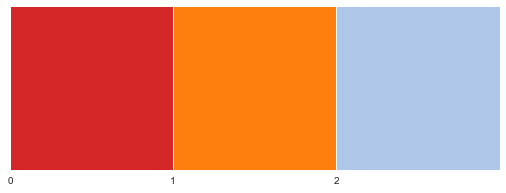

In [1297]:
cm = makeCmap('tab20', [6, 2, 1])
view_colormap(cm)

In [1298]:
def count_posi(df, rank):
    df_ = df[df['nnrank']>rank]
    pos = (df_['result']=='Active').sum()
    neg = (df_['result']=='Inactive').sum()
    return pos, neg

posi = np.zeros(150)
nega = np.zeros(150)
for i in range(1,151):
    pos, neg = count_posi(result, i)
    posi[i-1]=pos
    nega[i-1]=neg

tots = nega + posi


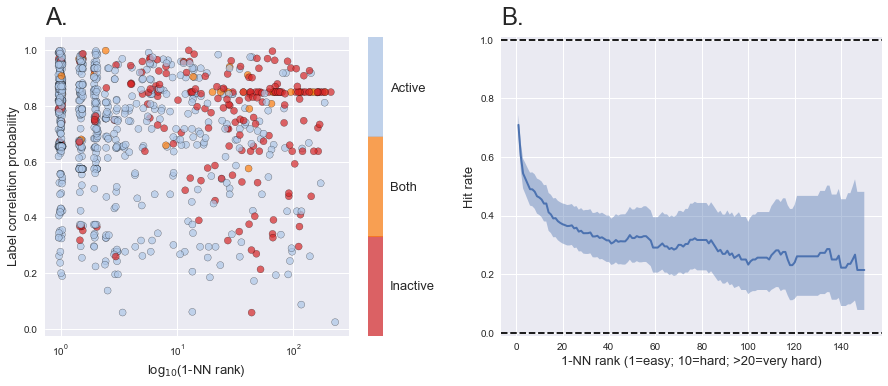

In [1311]:
fig, ax = plt.subplots(1,2)
#fig.set_figheight(15)
fig.set_figwidth(15)


jit = np.random.random(len(result))-0.5
jit /= 12
jit += 1

fsize=13

cax = ax[0].scatter(result['nnrank'].values*jit, 
            result['prob'].values.astype(float),
           c=result['result'].apply(lambda x: {'Active':1, 'Inactive':-1, 'Both':0}[x]),
           cmap = cm,
           alpha=0.7,
           edgecolor='k')
ax[0].set_xscale('log')

cbar = fig.colorbar(cax, ticks=[-0.66, 0, 0.66], ax=ax[0])
cbar.ax.set_yticklabels(['Inactive', 'Both', 'Active'], fontsize=fsize) 

ax[0].set_xlabel('log$_{10}}$(1-NN rank)', fontsize=fsize)
ax[0].set_ylabel('Label correlation probability', fontsize=fsize)


rate = posi/ tots

low = beta.ppf(0.025, posi+1, tots-posi+1)
high =beta.ppf(0.975, posi+1, tots-posi+1)

ax[1].fill_between(x=range(1,151),y1=low, y2=high,alpha=0.4)
ax[1].plot(range(1,151), rate, linewidth=2,)

ax[1].set_ylabel('Hit rate',fontsize=fsize)
ax[1].set_xlabel('1-NN rank (1=easy; 10=hard; >20=very hard)',fontsize=fsize)
ax[1].set_ylim(bottom=-0.01,top=1.01)
ax[1].axhline(0, linestyle='--', c='k')
ax[1].axhline(1, linestyle='--', c='k')

plot_fig_label(ax[0] ,'A.')
plot_fig_label(ax[1], 'B.')


fig.savefig('./figures/pubchem_validation.png')
fig.savefig('./figures/pubchem_validation.svg')
fig.savefig('./figures/pubchem_validation.tif')

In [1300]:
# stride = 12
# x = probs[probs.argsort()][::len(probs)//stride]
# digits = np.digitize(probs,x)
# nbin=len(x)
# for b in range(1,nbin):
# #for b in range(1,len(x[:-1])):
#     mask = digits==b
    
#     pos = ((d[0] - d[1])>0)[mask].sum()
#     neg = ((d[0] - d[1])<0)[mask].sum()
    
#     low = beta.ppf(0.025, pos+1, neg+1)
#     high = beta.ppf(0.975, pos+1, neg+1)
#     #print(pos/(pos+neg), low, high)
    
#     plt.plot([ x[b], x[b]], [low, high], c='k')
    
#     plt.scatter([x[b]], [pos/(pos+neg)],edgecolor = 'k', facecolor='white', linewidth=2)
    
# plt.ylim(0,1)
# plt.xlabel('Predicted probability')
# plt.ylabel('Hit rate')

### 

# Plotting:

In [798]:
def parse_group(group):
    inactive = group['outcome'].str.contains('Inactive').any()
    active = group['outcome'].str.contains('Active').any()
    if inactive and active:
        return 'Both'
    elif active and ~inactive:
        return 'Active'
    elif inactive and ~active:
        return 'Inactive'
    else:
        return False
    
def parse_group2(group):
    inactive = group['outcome'].str.contains('Inactive').sum()
    active = group['outcome'].str.contains('Active').sum()
    if (active - inactive) > 0:
        return 'Active'
    if (active - inactive) < 0:
        return 'Inactive'
    else:
        return 'Both'

collapse the assay data into per-ligand-target-pair results (i.e. `active`, `inactive`, `equal`).

Here also have the opportunity to select a protein family classification. 


In [1313]:
result

outcome,pref_name,lig_chemblid,prob,nnrank,result
0,3-phosphoinositide dependent protein kinase-1,CHEMBL2347053,0.455495,13.5,Active
1,3-phosphoinositide dependent protein kinase-1,CHEMBL3884319,0.504447,27.5,Active
2,ADAM17,CHEMBL43704,0.365403,2.0,Inactive
3,Acetylcholinesterase,CHEMBL240045,0.672720,1.0,Inactive
4,Acetylcholinesterase,CHEMBL322343,0.667318,1.0,Active
...,...,...,...,...,...
1006,c-Jun N-terminal kinase 1,CHEMBL535,0.941916,34.0,Inactive
1007,c-Jun N-terminal kinase 1,CHEMBL553,0.829682,49.0,Inactive
1008,c-Jun N-terminal kinase 1,CHEMBL91829,0.586161,21.0,Inactive
1009,c-Jun N-terminal kinase 1,CHEMBL939,0.695681,34.0,Inactive


In [987]:
#Mask 1-NN solutions:
#out = df[df['nnrank']>0].groupby(['lig_chemblid', 'pref_name']).apply(parse_group2)

#remove enzymes (anything with 'ase' in it)
filtered_df = df.merge(target_types, on='pref_name')
types = filtered_df.l1.unique()

t = types[4]
print(t)

out = filtered_df[filtered_df['l1']==t].groupby(['lig_chemblid', 'pref_name']).apply(parse_group2)

out_df= pd.DataFrame(out).reset_index().drop('lig_chemblid',axis=1)
out_df.columns=['pref_name', 'activity']

Membrane receptor


In [988]:
##Maybe a way simpler way to do it
# res = piv.reset_index()
# res['result'] = np.sign(res['Active'] - res['Inactive'])
# res.groupby('pref_name')['result'].sum()

In [989]:
import altair as alt


In [990]:
temp = out_df.groupby('pref_name').filter(lambda x : len(x)>0)
ch = alt.Chart(temp).mark_bar()

# ch = ch.encode(
#     x = alt.X('pref_name', sort='-y', title='Target preferred name'),
#     y = alt.Y('count()'),
#     color=alt.Color('activity'),
#     order=alt.Order('activity', sort='ascending'),
# )

ch = ch.encode(
    y = alt.Y('pref_name', sort='-x', title='Target preferred name'),
    x = alt.X('count()', title='Count'),
    color=alt.Color('activity'),
    order=alt.Order('activity', sort='ascending'),
    tooltip=['count()',]
).properties(height=850,width=400)

ch.configure_axisY(
titleFontSize=13,
).configure_axisX(
titleFontSize=13
).configure_axisBottom(labelAngle=-35).configure_header(
    titleFontSize=40, 
    labelFontSize=40
).configure_axisY(
    titleAngle=0,
    titleAlign="left",
    titleY=-10,
    titleX=-20,
    titleFontSize=16,
).configure_legend(orient='bottom',labelFontSize=22)

ch.interactive()

alt.Chart(...)

In [991]:
temp = out_df.groupby('pref_name').filter(lambda x : len(x)>2)
ch = alt.Chart(temp).mark_bar()

# ch = ch.encode(
#     x = alt.X('pref_name', sort='-y', title='Target preferred name'),
#     y = alt.Y('count()'),
#     color=alt.Color('activity'),
#     order=alt.Order('activity', sort='ascending'),
# )

ch = ch.encode(
    y = alt.Y('pref_name', sort='-x', title='Target preferred name'),
    x = alt.X('count()', title='Count'),
    color=alt.Color('activity'),
    order=alt.Order('activity', sort='ascending'),
).properties(height=500,width=300)

# ch.configure_axisY(
# titleFontSize=13,
# ).configure_axisX(
# titleFontSize=13
# ).configure_axisBottom(labelAngle=-35).configure_header(
#     titleFontSize=40, 
#     labelFontSize=40
# ).configure_axisY(
#     titleAngle=0,
#     titleAlign="left",
#     titleY=-10,
#     titleX=-20,
#     titleFontSize=16,
# ).configure_legend(orient='bottom',labelFontSize=22)

ch

alt.Chart(...)

In [980]:
ch = alt.Chart(out_df).mark_bar()

ch = ch.encode(
    x = alt.X('pref_name', sort='-y', title='Target preferred name'),
    y = alt.Y('count()'),
    color=alt.Color('activity'),
    order=alt.Order('activity', sort='ascending'),
).properties(height=200,width=750)
ch



alt.Chart(...)

# Getting target classes:

In [894]:
target_types = pd.read_csv('target_classes.csv')

In [895]:
target_types

,chembl_id,l1,l2,l3,pref_name
0,CHEMBL3568,Enzyme,NaN,NaN,"Nitric-oxide synthase, brain"
1,CHEMBL2963,Enzyme,Protease,Metallo protease,Matrix metalloproteinase 15
2,CHEMBL2227,Ion channel,Other ion channel,Pore-forming toxins (proteins and peptides),Proenkephalin B
3,CHEMBL5208,Transporter,Electrochemical transporter,SLC superfamily of solute carriers,GABA transporter 3
4,CHEMBL3338,Enzyme,NaN,NaN,Squalene synthetase
...,...,...,...,...,...
3148,CHEMBL3989381,Unclassified protein,NaN,NaN,Hepcidin
3149,CHEMBL3989382,Unclassified protein,NaN,NaN,Macrophage colony-stimulating factor 1
3150,CHEMBL3989383,Unclassified protein,NaN,NaN,Tumor necrosis factor receptor superfamily mem...
3151,CHEMBL3989384,Unclassified protein,NaN,NaN,Cadherin-3


In [896]:
df.merge(target_types, on='pref_name')

,tid,pref_name,lig_chemblid,aid,outcome,title,nnrank,chembl_id,l1,l2,l3
0,CHEMBL261,Carbonic anhydrase I,CHEMBL2326507,727274,Inactive,inhibition of full length human recombinant fu...,1.5,CHEMBL261,Enzyme,Lyase,NaN
1,CHEMBL261,Carbonic anhydrase I,CHEMBL215355,271037,Active,inhibition of human cloned ca1 by co2 hydratio...,1.0,CHEMBL261,Enzyme,Lyase,NaN
2,CHEMBL261,Carbonic anhydrase I,CHEMBL215276,271037,Active,inhibition of human cloned ca1 by co2 hydratio...,1.0,CHEMBL261,Enzyme,Lyase,NaN
3,CHEMBL261,Carbonic anhydrase I,CHEMBL6852,47713,Active,inhibition of human carbonic anhydrase i cai,2.0,CHEMBL261,Enzyme,Lyase,NaN
4,CHEMBL261,Carbonic anhydrase I,CHEMBL6852,50367,Active,inhibitory activity against human carbonic anh...,2.0,CHEMBL261,Enzyme,Lyase,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2105,CHEMBL1914,Butyrylcholinesterase,CHEMBL3604192,1240923,Active,inhibition of equine serum bche using atc iodi...,1.0,CHEMBL1914,Enzyme,Hydrolase,NaN
2106,CHEMBL3973,Fibroblast growth factor receptor 4,CHEMBL3961994,1344879,Active,kinase hotspot xe2 xbf xa2 assay: compounds we...,1.5,CHEMBL3973,Enzyme,Kinase,Protein Kinase
2107,CHEMBL3973,Fibroblast growth factor receptor 4,CHEMBL3961994,1344879,Active,kinase hotspot xe2 xbf xa2 assay: compounds we...,1.5,CHEMBL3973,Enzyme,Kinase,Protein Kinase
2108,CHEMBL3973,Fibroblast growth factor receptor 4,CHEMBL3961994,1344881,Active,kinase hotspot xe2 xbf xa2 assay: compounds we...,1.5,CHEMBL3973,Enzyme,Kinase,Protein Kinase


In [883]:
df

,tid,pref_name,lig_chemblid,aid,outcome,title,nnrank
0,CHEMBL261,Carbonic anhydrase I,CHEMBL2326507,727274,Inactive,inhibition of full length human recombinant fu...,1.5
1,CHEMBL222,Norepinephrine transporter,CHEMBL3126751,1075730,Active,displacement of [3h]nisoxetine from sprague da...,11.5
2,CHEMBL261,Carbonic anhydrase I,CHEMBL215355,271037,Active,inhibition of human cloned ca1 by co2 hydratio...,1.0
3,CHEMBL321,Matrix metalloproteinase 9,CHEMBL43147,310906,Active,inhibition of mmp9,1.0
4,CHEMBL333,Matrix metalloproteinase-2,CHEMBL348335,107154,Active,inhibitory activity against human gelatinase a...,3.0
...,...,...,...,...,...,...,...
1864,CHEMBL216,Muscarinic acetylcholine receptor M1,CHEMBL1724,602247,Inactive,full deck counterscreen for positive allosteri...,1.0
1865,CHEMBL216,Muscarinic acetylcholine receptor M1,CHEMBL1724,602248,Inactive,full deck counterscreen for agonists of the hu...,1.0
1866,CHEMBL216,Muscarinic acetylcholine receptor M1,CHEMBL1724,602250,Inactive,full deck counterscreen for antagonists of the...,1.0
1867,CHEMBL262,Glycogen synthase kinase-3 beta,CHEMBL553,1117336,Active,gsk3b pretreated hct116 viability from cell ti...,59.0
